<a href="https://colab.research.google.com/github/PsorTheDoctor/robotics/blob/main/notebooks/ransac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RANSAC (Random Sample Consensus)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class LinearLeastSquaresModel:

  def __init__(self, input_columns, output_columns):
    self.input_columns = input_columns
    self.output_columns = output_columns

  def fit(self, data):
    A = np.vstack([data[:, i] for i in self.input_columns]).T
    B = np.vstack([data[:, i] for i in self.output_columns]).T
    x, residues, rank, s = np.linalg.lstsq(A, B)
    return x

  def get_error(self, data, model):
    A = np.vstack([data[:, i] for i in self.input_columns]).T
    B = np.vstack([data[:, i] for i in self.output_columns]).T
    B_fit = np.dot(A, model)
    error_per_point = np.sum((B - B_fit) ** 2, axis=1)
    return error_per_point

In [3]:
def ransac(data, model):
  n = 50  # Najmniejsza liczba punktów potrzebnych do estymacji parametrów modelu
  k = 1000  # Największa liczba możliwych iteracji
  t = 7e3  # Wartość progowa określająca dopasowanie chmury punktów do modelu
  d = 300  # Liczba przybliżonych wartości potrzebnych do uznania, że model 
           # pasuje do chmury punktów
  i = 0
  best_fit = None
  best_error = np.inf

  while i < k:
    possible_indices, test_indices = random_partition(n, data.shape[0])
    possible_inliers = data[possible_indices, :]
    test_points = data[test_indices]
    possible_model = model.fit(possible_inliers)
    test_error = model.get_error(test_points, possible_model)
    indices = test_indices[test_error < t]
    inliers = data[indices, :]

    if len(inliers) > d:
      better_data = np.concatenate((possible_inliers, inliers))
      better_model = model.fit(better_data)
      better_errors = model.get_error(better_data, better_model)
      error = np.mean(better_errors)
      if error < best_error:
        best_fit = better_model
        best_error = error
        best_inlier_indices = np.concatenate((possible_indices, indices))
    i += 1

  return best_fit

def random_partition(n, n_data):
  all_indices = np.arange(n_data)
  np.random.shuffle(all_indices)
  indices1 = all_indices[:n]
  indices2 = all_indices[n:]
  return indices1, indices2

In [5]:
n_samples = 500
A_exact = 20 * np.random.random((n_samples, 1))
perfect_fit = 60 * np.random.normal(size=(1, 1))
B_exact = np.dot(A_exact, perfect_fit)
assert B_exact.shape == (n_samples, 1)

# Dodanie małego szumu gaussowskiego
A_noisy = A_exact + np.random.normal(size=A_exact.shape)
B_noisy = B_exact + np.random.normal(size=B_exact.shape)

# Dodanie punktów odstających
n_outliers = 100
all_indices = np.arange(A_noisy.shape[0])
np.random.shuffle(all_indices)
outlier_indices = all_indices[:n_outliers]
non_outlier_indices = all_indices[n_outliers:]
A_noisy[outlier_indices] = 20 * np.random.random((n_outliers, 1))
B_noisy[outlier_indices] = 50 * np.random.normal(size=(n_outliers, 1))

all_data = np.hstack((A_noisy, B_noisy))
input_columns = range(1)
output_columns = [1 + i for i in range(1)]  # [1]
model = LinearLeastSquaresModel(input_columns, output_columns)

linear_fit, residues, rank, s = np.linalg.lstsq(all_data[:, input_columns],
                                                all_data[:, output_columns])
ransac_fit = ransac(all_data, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


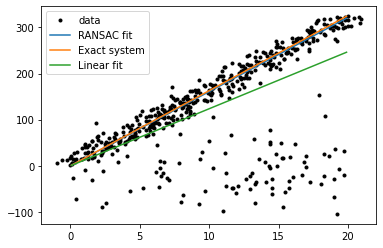

In [6]:
sorted_indices = np.argsort(A_exact[:, 0])
A_col0_sorted = A_exact[sorted_indices]

plt.plot(A_noisy[:, 0], B_noisy[:, 0], 'k.', label='data')

plt.plot(A_col0_sorted[:, 0], np.dot(A_col0_sorted, ransac_fit)[:, 0], 
         label='RANSAC fit')
plt.plot(A_col0_sorted[:, 0], np.dot(A_col0_sorted, perfect_fit)[:, 0], 
         label='Exact system')
plt.plot(A_col0_sorted[:, 0], np.dot(A_col0_sorted, linear_fit)[:, 0], 
         label='Linear fit')
plt.legend()
plt.show()